In [4]:
import xarray as xr
import numpy as np
import pandas as pd

In [5]:
%load_ext sql
%sql postgresql://localhost:5432/grav_29_1
%sql create extension if not exists postgis
%sql

 * postgresql://localhost:5432/grav_29_1
Done.
 * postgresql://localhost:5432/grav_29_1


In [6]:
# plotting modules
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
def raster_filter_range(raster0, g1, g2):
    raster = raster0.copy()
    raster.values = raster.values.astype(np.float32)
    raster.values = gaussian_filter(raster.values,g1,mode='constant', cval=0) \
            - gaussian_filter(raster.values,g2,mode='constant', cval=0)
    return raster

def spectrum(raster, gammas, dgamma = 1.0):
    rasters = []
    for g in gammas:
        print (g,". ", end = '')
        _raster = raster_filter_range(raster, g-dgamma/2, g+dgamma/2)
        rasters.append(_raster)
    return rasters

## Parameters

In [7]:
# Gaussian filter sigma, km
sigmaskm = np.linspace(25,1025,21)
sigmaskm

array([  25.,   75.,  125.,  175.,  225.,  275.,  325.,  375.,  425.,
        475.,  525.,  575.,  625.,  675.,  725.,  775.,  825.,  875.,
        925.,  975., 1025.])

## Raster from file

In [11]:
# grav_29.1.10min.nc regridded from Open Sandwell and Smith Global Gravity Grid grav_29.1nc
da = xr.open_dataarray('grav_29.1.10min.nc').squeeze(drop=True)
da

<xarray.DataArray (lat: 960, lon: 2160)>
[2073600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.8 179.9
  * lat      (lat) float64 -79.92 -79.75 -79.58 -79.42 ... 79.58 79.75 79.92

## Raster to Database

In [6]:
%%time
da.to_dataframe(name='z').to_csv('data.csv', header=False)

CPU times: user 6.63 s, sys: 327 ms, total: 6.95 s
Wall time: 7.42 s


In [7]:
fname = !pwd
fname = fname[0] + '/data.csv'

In [8]:
%%time
%%sql

create extension if not exists postgis;
drop table if exists data;
create table data (lat float, lon float, z float, the_geom geography(Point, 4326));
COPY data (lat, lon, z) FROM :fname WITH DELIMITER ',';
UPDATE data SET the_geom = ST_SetSRID(ST_MakePoint(lon, lat), 4326);
CREATE INDEX data_the_geom_idx ON data USING GIST (the_geom);
ANALYZE data;

 * postgresql://localhost:5432/grav_29_1
Done.
Done.
Done.
2073600 rows affected.
2073600 rows affected.
Done.
Done.
CPU times: user 18.1 ms, sys: 6.34 ms, total: 24.4 ms
Wall time: 47.8 s


[]

## Grid to Database

In [24]:
grid = da[::150,::150]
print (grid.shape[0]*grid.shape[1])
grid

105


<xarray.DataArray (lat: 7, lon: 15)>
array([[-2.470154e+01, -3.991613e+01, -2.148868e+01, -1.174369e+01,
        -1.070461e+01, -1.922544e+01, -2.418853e+01, -2.357659e-01,
        -4.639017e+00,  2.044112e+01,  3.222401e+01,  1.033136e+01,
        -3.062135e+01, -5.027039e+01, -1.425050e+01],
       [-2.046248e+01, -6.254662e+00, -5.035788e+01, -2.780522e+00,
        -3.969754e+00,  4.103281e+00, -1.818015e+02,  2.214186e+01,
        -2.556896e+00,  2.656392e+01,  1.864497e+01,  8.709051e+00,
        -3.554158e+00,  1.405143e+01, -3.484762e+01],
       [ 7.632655e+01, -5.490781e+00, -1.200343e+01, -4.810857e-01,
         4.109659e+00, -1.821235e+01, -7.569246e+00, -1.929038e+00,
         3.038274e+01,  3.174907e+01,  1.284760e+00, -3.147309e+00,
        -1.752925e+01,  4.383108e+00,  1.945332e+01],
       [-7.246820e+00,  9.552965e+00,  1.691154e+00,  4.290150e-01,
         2.603105e+02, -3.687209e+01,  6.669695e+00,  6.098282e+00,
        -2.654197e+01, -3.033238e+01, -2.935696e+01, -2.093115e+01,
         7.043114e+01, -1.343248e+02,  6.958040e+00],
       [-1.057861e+01, -1.776380e+01, -2.104509e+01,  3.143086e+00,
        -2.241426e+01, -4.827692e-02,  2.136380e+01,  3.711421e+00,
        -3.422861e+01, -4.150450e+00,  2.534719e+00, -4.651197e+01,
        -1.203728e+01,  9.428467e+01, -1.073825e+01],
       [-1.828432e+00, -3.804326e+00, -5.186862e+00,  4.479924e+01,
        -5.045031e+00,  2.337797e+01,  3.617480e+01, -2.020804e+01,
         2.350285e+01, -2.997655e+01, -5.599803e+01,  1.678144e+01,
         1.586006e+01, -4.144685e+00,  1.622001e+02],
       [-3.856820e+00, -1.360225e+01, -2.219794e+01, -3.673196e+01,
        -4.276756e+01,  1.780105e+01,  1.252088e+00,  3.591130e+01,
        -3.410636e+01, -7.295687e+00, -8.146863e+00,  9.668027e-01,
         2.089571e+01, -6.370893e+00, -1.172984e+01]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -179.9 -154.9 -129.9 -104.9 ... 120.1 145.1 170.1
  * lat      (lat) float64 -79.92 -54.92 -29.92 -4.917 20.08 45.08 70.08

In [25]:
grid.to_dataframe(name='z0').to_csv('grid.csv', header=False)

In [26]:
fname = !pwd
fname = fname[0] + '/grid.csv'

In [27]:
%%time
%%sql

drop table if exists grid;
create table grid (lat float, lon float, z0 float, the_geom geography(Point, 4326));
COPY grid (lat, lon, z0) FROM :fname WITH DELIMITER ',';
UPDATE grid SET the_geom = ST_SetSRID(ST_MakePoint(lon, lat), 4326);
CREATE INDEX grid_the_geom_idx ON grid USING GIST (the_geom);
ANALYZE grid;

 * postgresql://localhost:5432/grav_29_1
Done.
Done.
105 rows affected.
105 rows affected.
Done.
Done.
CPU times: user 10.5 ms, sys: 4.21 ms, total: 14.7 ms
Wall time: 90.1 ms


[]

## Gaussian Filtering in Database

In [28]:
%%sql

DROP FUNCTION IF EXISTS gaussian_transform(sigma float, geom geography);
CREATE OR REPLACE FUNCTION gaussian_transform(sigma float, geom geography)
    RETURNS TABLE (z float, count bigint)
    AS '
with weights as (
    select
        z,
        exp(-(pow(ST_Distance($2,the_geom,false),2))/(2*pow($1,2))) as weight
    from data
    where ST_Buffer($2,4.*$1) && the_geom and ST_DWithin($2, the_geom, 4.*$1)
)
select
    sum(z*weight)/sum(weight) as z,
    count(1) as count
from weights
'
LANGUAGE SQL STABLE;

 * postgresql://localhost:5432/grav_29_1
Done.
Done.


[]

In [29]:
%%time

%sql drop table if exists gaussian_transform;
%sql create table gaussian_transform (sigmakm int, lat float, lon float, z0 float, z float, count bigint);

for sigmakm in sigmaskm:
    print ("sigmakm", sigmakm)
    %sql insert into gaussian_transform \
         select :sigmakm, lat, lon, z0, t.* from grid, gaussian_transform(:sigmakm*1000, the_geom) as t;

 * postgresql://localhost:5432/grav_29_1
Done.
 * postgresql://localhost:5432/grav_29_1
Done.
sigmakm 25.0
 * postgresql://localhost:5432/grav_29_1
105 rows affected.
sigmakm 75.0
 * postgresql://localhost:5432/grav_29_1
105 rows affected.
sigmakm 125.0
 * postgresql://localhost:5432/grav_29_1
105 rows affected.
sigmakm 175.0
 * postgresql://localhost:5432/grav_29_1
105 rows affected.
sigmakm 225.0
 * postgresql://localhost:5432/grav_29_1
105 rows affected.
sigmakm 275.0
 * postgresql://localhost:5432/grav_29_1
105 rows affected.
sigmakm 325.0
 * postgresql://localhost:5432/grav_29_1
105 rows affected.
sigmakm 375.0
 * postgresql://localhost:5432/grav_29_1
105 rows affected.
sigmakm 425.0
 * postgresql://localhost:5432/grav_29_1
105 rows affected.
sigmakm 475.0
 * postgresql://localhost:5432/grav_29_1
105 rows affected.
sigmakm 525.0
 * postgresql://localhost:5432/grav_29_1
105 rows affected.
sigmakm 575.0
 * postgresql://localhost:5432/grav_29_1
105 rows affected.
sigmakm 625.0
 * pos

## Show Gaussian Transform map

In [30]:
%sql gaussian << select * from gaussian_transform

 * postgresql://localhost:5432/grav_29_1
2205 rows affected.
Returning data to local variable gaussian


In [31]:
gaussian = gaussian.DataFrame()

In [33]:
gaussian = gaussian.set_index(['sigmakm','lat','lon']).to_xarray()
gaussian

<xarray.Dataset>
Dimensions:  (lat: 7, lon: 15, sigmakm: 21)
Coordinates:
  * sigmakm  (sigmakm) int64 25 75 125 175 225 275 ... 775 825 875 925 975 1025
  * lat      (lat) float64 -79.92 -54.92 -29.92 -4.917 20.08 45.08 70.08
  * lon      (lon) float64 -179.9 -154.9 -129.9 -104.9 ... 120.1 145.1 170.1
Data variables:
    z0       (sigmakm, lat, lon) float64 -24.7 -39.92 -21.49 ... -6.371 -11.73
    z        (sigmakm, lat, lon) float64 -23.81 -36.38 -21.21 ... -0.2921 0.9441
    count    (sigmakm, lat, lon) int64 286 286 286 286 ... 314323 314311 314432

In [41]:
%%time
# discrete power spectrum
power_spectrum = gaussian.std(['lat','lon'])['z'].rename('spectrum')

CPU times: user 1.25 ms, sys: 171 µs, total: 1.42 ms
Wall time: 1.29 ms


In [42]:
power_spectrum

<xarray.DataArray 'spectrum' (sigmakm: 21)>
array([30.68737478, 21.05581914, 17.4032135 , 15.7300803 , 14.76182771,
       14.06991956, 13.49769975, 12.99482749, 12.54076833, 12.12317559,
       11.73345841, 11.36513933, 11.0136197 , 10.67513224, 10.34752028,
       10.02944297,  9.72033567,  9.41968698,  9.1273268 ,  8.84322496,
        8.56711385])
Coordinates:
  * sigmakm  (sigmakm) int64 25 75 125 175 225 275 ... 775 825 875 925 975 1025

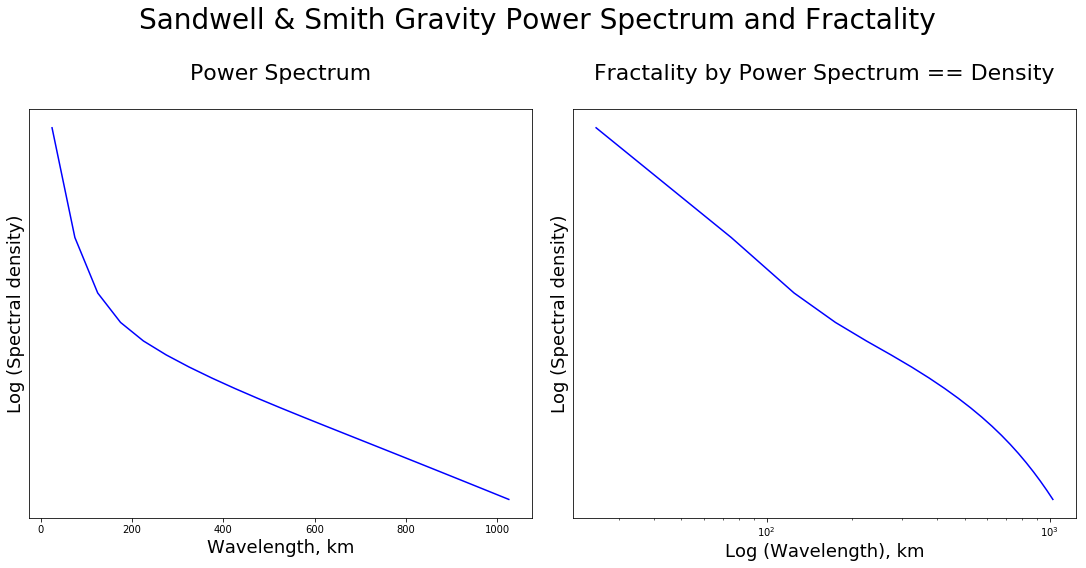

In [59]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1, 2, 1)
ax.plot(power_spectrum.sigmakm.values, power_spectrum.values, c='blue')
ax.set_yscale('log')
ax.set_title(f'Power Spectrum\n', fontsize=22)
#ax.axvline(x=std/2, ymin=0, ymax=1, color = 'red', ls='dotted')
#ax.text(std/2-2.5, ax.get_ylim()[0], "½ std", color="red", fontsize=16)
ax.set_ylabel('Log (Spectral density)',fontsize=18)
ax.set_xlabel('Wavelength, km', fontsize=18)
ax.set_yticks([])
ax.set_yticks([], minor=True)

ax = fig.add_subplot(1, 2, 2)
ax.plot(power_spectrum.sigmakm.values, power_spectrum.values, c='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(f'Fractality by Power Spectrum == Density\n', fontsize=22)
#ax.axvline(x=std/2, ymin=0, ymax=1, color = 'red', ls='dotted')
#ax.text(std/2-2.5, ax.get_ylim()[0], "½ std", color="red", fontsize=16)
ax.set_ylabel('Log (Spectral density)',fontsize=18)
ax.set_xlabel('Log (Wavelength), km', fontsize=18)
ax.set_yticks([])
ax.set_yticks([], minor=True)


plt.suptitle('Sandwell & Smith Gravity Power Spectrum and Fractality', fontsize=28)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.savefig('Spectral Components Analysis [Sandwell & Smith].jpg', dpi=150, quality=95)
plt.show()